In [1]:
# Стандартные библиотеки
import os
import random
import re

# Библиотеки работы с данными и изображениями
import cv2
import numpy as np
from PIL import Image
from skimage.feature import hog

# Машинное обучение и анализ данных
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Визуализация
import matplotlib.pyplot as plt

Используя набор данных data, сгенерируйте последовательность символов вида
наличие/отсутствие открывающейся скобки, число/буква, знак операции,
число/буква, наличие/отсутствие закрывающейся скобки

In [2]:
def generate_expression(
    digits: list[str] = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
    letters: list[str] = ['h', 'w', 'X', 'y'],
    operations: list[str] = ['+', '-', 'times'],
) -> list[str]:
    """
    Генерирует случайное выражение в виде списка токенов.
    
    Каждое выражение состоит из:
    - левого операнда (цифра или буква),
    - операции (+, -, times),
    - правого операнда (цифра или буква),
    - опциональных скобок в начале и/или конце.
    
    Returns:
        list[str]: Список строк, представляющих выражение.
    """
    tokens = []

    left = random.choice(digits + letters)
    op = random.choice(operations)
    right = random.choice(digits + letters)

    tokens.extend([left, op, right])

    if random.choice([True, False]):
        tokens.insert(0, '(')
    if random.choice([True, False]):
        tokens.append(')')

    return tokens


# Пример использования
for _ in range(5):
    expression = generate_expression()
    print(''.join(expression))

5+w)
(X-3
6+0
(X+h
(Xtimes6)


# b. Символы соответствую классам данных архива data.
# c. На основе сгененированной последовательности создайте последовательность изображений символов, где каждому символу соотвествует случайное изображение набора данных соотвествующего класса.

In [3]:
from pathlib import Path


def get_random_image(folder_name: str) -> Image.Image:
    """
    Возвращает случайное изображение из указанной папки.

    Args:
        folder_name (str): Название подпапки внутри директории 'data',
                           содержащей изображения.

    Returns:
        Image.Image: Открытое изображение с помощью библиотеки PIL.

    Raises:
        ValueError: Если папка не существует или не содержит изображений.
    """
    data_dir = Path.cwd() / 'data' / folder_name
    folder_path = data_dir.resolve()

    if not folder_path.exists():
        raise ValueError(f"Папка {folder_path} не существует")

    image_files = [f for f in folder_path.iterdir() if f.suffix.lower() in ('.png', '.jpg', '.jpeg')]
    if not image_files:
        raise ValueError(f"В папке {folder_path} нет изображений")

    return Image.open(random.choice(image_files))

Сгенерированное выражение: 8-1)


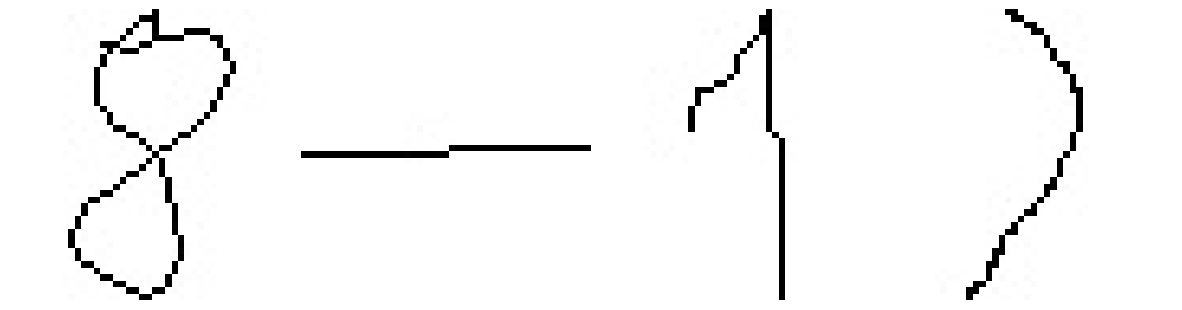

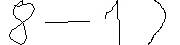

In [4]:
def generate_expression_with_images(tokens: list[str], save_path = None) -> Image.Image:
    """
    Генерирует объединённое изображение из случайных картинок,
    соответствующих каждому символу в выражении.

    Args:
        tokens (list[str]): Список символов (токенов), представляющих выражение.
        save_path (Optional[str]): Путь для сохранения результата (если указан).

    Returns:
        Image.Image: Объединённое изображение выражения.
    """
    # Загружаем случайные изображения для каждого токена
    images = [get_random_image(sym) for sym in tokens]

    # Вычисляем размеры итогового изображения
    total_width = sum(img.width for img in images)
    max_height = max(img.height for img in images)

    # Создаем новое белое изображение
    combined_image = Image.new('RGB', (total_width, max_height), 'white')

    # Вклеиваем каждое изображение по порядку
    x_offset = 0
    for img in images:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width

    # Отображаем результат
    plt.figure(figsize=(15, 5))
    plt.imshow(combined_image)
    plt.axis('off')
    plt.show()

    # Сохраняем, если указан путь
    if save_path:
        combined_image.save(save_path)
        print(f"Изображение сохранено в {save_path}")

    return combined_image


# Пример использования
expr = generate_expression()
print(f"Сгенерированное выражение: {''.join(expr)}")
generate_expression_with_images(expr)

# d. Обучите метод knn для обучающей последовательности. Для обучающей выборки выберите 10-20 изображений каждого класса.


In [5]:
def load_images_from_folder_hog(
    folder_path: str,
    label: str,
    limit: int = 20,
    size: tuple[int, int] = (45, 45)
) -> list[tuple[np.ndarray, str]]:
    """
    Загружает изображения из указанной папки и извлекает HOG-признаки.

    Args:
        folder_path (str): Путь к папке с изображениями.
        label (str): Метка класса для всех изображений из этой папки.
        limit (int): Максимальное количество изображений для загрузки.
        size (tuple): Размер, к которому будут приведены изображения.

    Returns:
        list[tuple[np.ndarray, str]]: Список пар (HOG-признаки, метка).
    """
    features_list = []
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    random.shuffle(image_files)
    selected_files = image_files[:limit]

    for filename in selected_files:
        full_path = os.path.join(folder_path, filename)
        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            continue

        img = cv2.resize(img, size)
        features = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=False
        )
        features_list.append((features, label))

    return features_list


def prepare_training_data_hog(
    data_root: str = "data",
    limit_per_class: int = 20
) -> tuple[np.ndarray, np.ndarray]:
    """
    Подготавливает обучающие данные: загружает изображения и извлекает HOG-признаки.

    Args:
        data_root (str): Корневая директория с подпапками по классам.
        limit_per_class (int): Максимальное количество изображений на класс.

    Returns:
        tuple[np.ndarray, np.ndarray]: Массив признаков X и массив меток y.
    """
    all_data = []

    for label in os.listdir(data_root):
        folder_path = os.path.join(data_root, label)

        if os.path.isdir(folder_path):
            samples = load_images_from_folder_hog(folder_path, label, limit=limit_per_class)
            all_data.extend(samples)

    X = np.array([x for x, _ in all_data])
    y = np.array([y for _, y in all_data])

    return X, y


def train_knn_classifier(
    X: np.ndarray,
    y: np.ndarray,
    n_neighbors: int = 3
) -> KNeighborsClassifier:
    """
    Обучает KNN-классификатор на переданных данных.

    Args:
        X (np.ndarray): Массив признаков.
        y (np.ndarray): Массив меток.
        n_neighbors (int): Количество соседей для KNN.

    Returns:
        KNeighborsClassifier: Обученный классификатор.
    """
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(X, y)
    return knn


# --- Основной процесс обучения ---
X_hog, y_hog = prepare_training_data_hog(data_root="data", limit_per_class=20)
knn_hog = train_knn_classifier(X_hog, y_hog, n_neighbors=3)

acc = knn_hog.score(X_hog, y_hog)
print(f"Точность на отложенной выборке: {acc:.3f}")

Точность на отложенной выборке: 0.795


# e. Выполните классификацию последовательности символов шага с.

Сгенерированное выражение: (4times9)


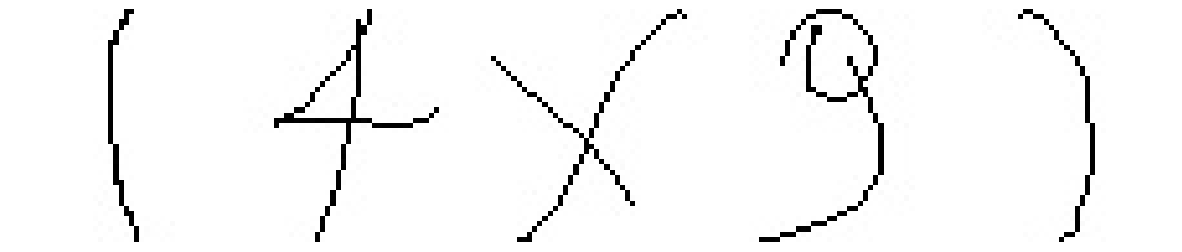

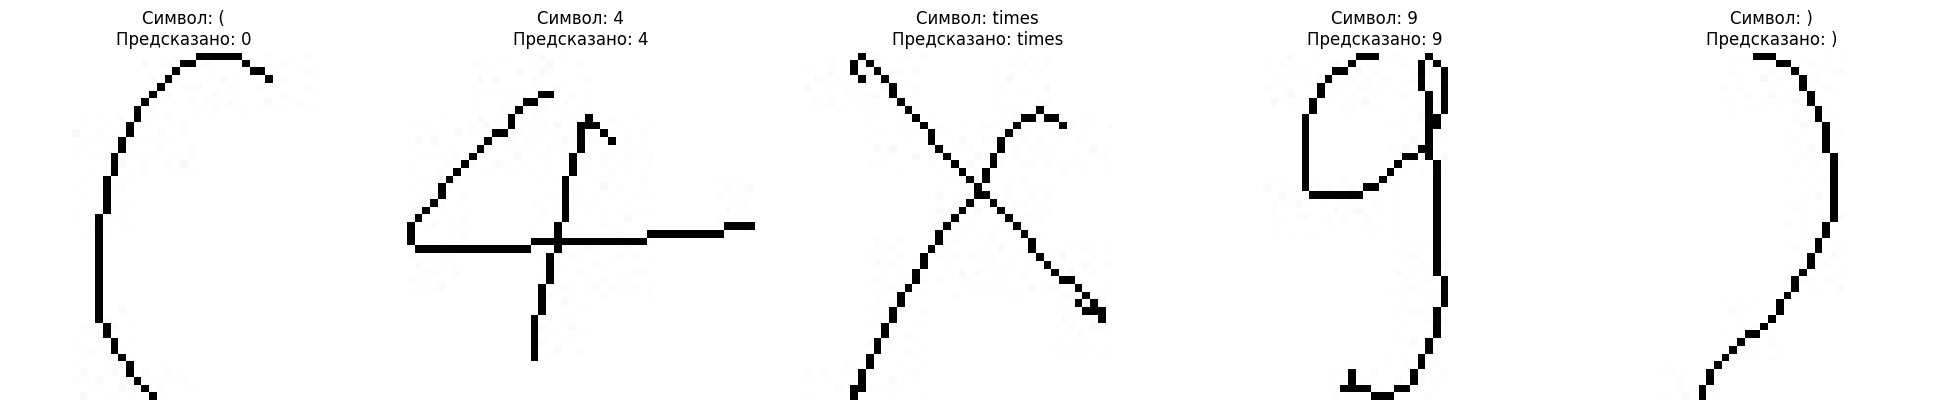

Распознанное выражение: 04times9)


In [6]:
def classify_symbol_image_hog(
    knn_model: KNeighborsClassifier,
    img: Image.Image,
    size: tuple[int, int] = (45, 45)
) -> str:
    """
    Классифицирует изображение символа с использованием обученного KNN-модели.

    Args:
        knn_model (KNeighborsClassifier): Обученная модель классификации.
        img (Image.Image): Изображение символа в формате PIL.
        size (tuple): Размер, к которому будет приведено изображение.

    Returns:
        str: Предсказанная метка символа.
    """
    # Конвертируем PIL Image в numpy array
    img_np = np.array(img)

    # Если изображение цветное — конвертируем в grayscale
    if len(img_np.shape) == 3:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    img_resized = cv2.resize(img_np, size)

    features = hog(
        img_resized,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False
    )

    features = features.reshape(1, -1)
    prediction = knn_model.predict(features)

    return prediction[0]


def classify_expression_image(
    knn_model: KNeighborsClassifier,
    expression: list[str]
) -> str:
    """
    Распознаёт каждое изображение символа в выражении и выводит результат.

    Args:
        knn_model (KNeighborsClassifier): Обученная модель классификации.
        expression (list[str]): Список символов, представляющих выражение.

    Returns:
        str: Строка, содержащая распознанные символы.
    """
    images = []
    labels = []
    predicted = []

    for symbol in expression:
        try:
            img = get_random_image(symbol)
            label = classify_symbol_image_hog(knn_model, img)

            predicted.append(label)
            images.append(np.array(img))
            labels.append((symbol, label))

        except ValueError as e:
            print(f"Ошибка для символа {symbol}: {str(e)}")
            predicted.append('?')
            continue

    n_images = len(images)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 4, 4))

    if n_images == 1:
        axes = [axes]

    for ax, img, (symbol, label) in zip(axes, images, labels):
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Символ: {symbol}\nПредсказано: {label}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    return ''.join(predicted)


# --- Пример использования ---
if __name__ == "__main__":
    expr = generate_expression()
    expr_str = ''.join(expr)
    print("Сгенерированное выражение:", expr_str)

    # Показываем изображение выражения
    expr_img = generate_expression_with_images(expr)

    # Распознаём выражение посимвольно
    recognized_expr = classify_expression_image(knn_hog, expr)
    print("Распознанное выражение:", recognized_expr)

# f. При помощи регулярных строк проверьте полученное выражение на корректность.

Сгенерированное выражение: (Xtimes3)

Проверка исходного выражения:
Выражение не прошло проверку: (Xtimes3)


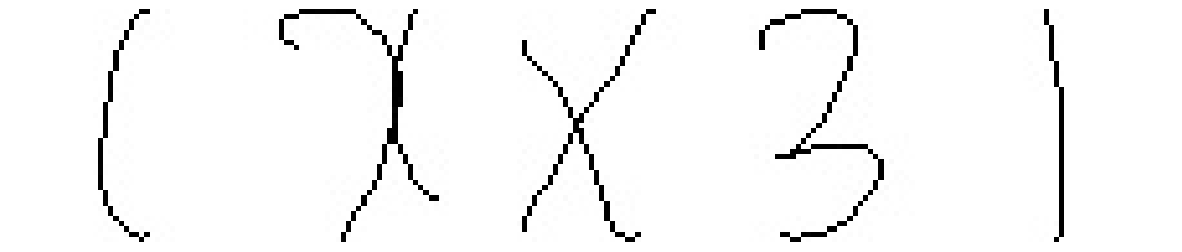

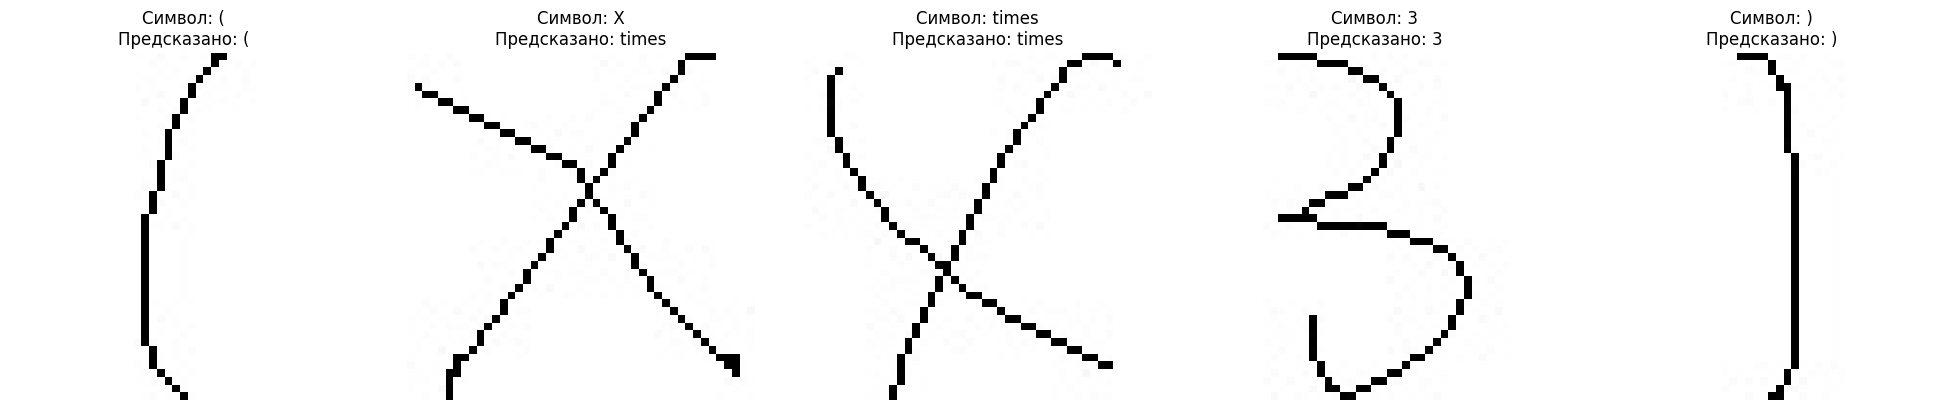


Распознанное выражение: (timestimes3)

Проверка распознанного выражения:
Выражение не прошло проверку: (timestimes3)

Сравнение результатов:
Исходное выражение: (Xtimes3)
Распознанное выражение: (timestimes3)
Выражения не совпадают


In [7]:
import re
from typing import Literal


def check_expression_regex(expr: str) -> bool:
    """
    Проверяет корректность формата выражения с помощью регулярного выражения.

    Формат выражения:
        [опциональная '('] + [операнд] + [операция] + [операнд] + [опциональная ')']
    
    Операнды могут содержать: цифры (0-9), h, w, X, y.
    Операции: +, -, times.

    Args:
        expr (str): Выражение для проверки.

    Returns:
        bool: True, если выражение соответствует шаблону, иначе False.
    """
    # Регулярное выражение для валидации выражения
    pattern = re.compile(r'^$(?:[0-9hwXy]+)(\+|\-|times)([0-9hwXy]+)\)?$')

    match = pattern.match(expr)

    if match:
        left, op, right = match.groups()
        print(f"Выражение корректно: {expr}")
        print(f"    Левый операнд: {left}")
        print(f"    Операция: {op}")
        print(f"    Правый операнд: {right}")
        return True

    else:
        print(f"Выражение не прошло проверку: {expr}")
        return False


# --- Пример использования ---
if __name__ == "__main__":
    # Генерируем выражение
    expr = generate_expression()
    expr_str = ''.join(expr)
    print("Сгенерированное выражение:", expr_str)

    # Проверяем исходное выражение
    print("\nПроверка исходного выражения:")
    is_valid = check_expression_regex(expr_str)

    # Отображаем изображение выражения
    expr_img = generate_expression_with_images(expr)

    # Распознаём выражение посимвольно
    recognized_expr = classify_expression_image(knn_hog, expr)
    print("\nРаспознанное выражение:", recognized_expr)

    # Проверяем распознанное выражение
    print("\nПроверка распознанного выражения:")
    is_recognized_valid = check_expression_regex(recognized_expr)

    # Сравниваем результаты
    print("\nСравнение результатов:")
    print(f"Исходное выражение: {expr_str}")
    print(f"Распознанное выражение: {recognized_expr}")
    print(f"Выражения {'совпадают' if expr_str == recognized_expr else 'не совпадают'}")

## g.	Если выражение корректно, вычислите результат, закодированный арифметическим выражением.

In [8]:
# Вывод последовательности
expression = ''.join(expr)
print("Сгенерированная последовательность символов:", expression)

# Проверка и вычисление результата
try:
    # Удаляем скобки, если они есть
    clean_expression = expression.replace('(', '').replace(')', '')

    # Определяем оператор с учетом приоритета (в порядке убывания ожидаемой частоты)
    op = None
    for operator in ['+', '-', '*', '/']:
        if operator in clean_expression:
            op = operator
            break

    if op is None:
        raise ValueError("Не найден арифметический оператор в выражении")

    # Разделяем на операнды
    parts = clean_expression.split(op)
    if len(parts) != 2:
        raise ValueError("Выражение должно содержать ровно два числа и один оператор")

    num1_str, num2_str = parts
    num1 = int(num1_str.strip())
    num2 = int(num2_str.strip())

    # Выполняем операцию
    if op == '+':
        result = num1 + num2
    elif op == '-':
        result = num1 - num2
    elif op == '*':
        result = num1 * num2
    elif op == '/':
        if num2 == 0:
            raise ZeroDivisionError("Деление на ноль")
        result = num1 / num2

    print(f"Результат: {num1} {op} {num2} = {result}")

except ValueError as ve:
    print("Ошибка валидации выражения:", ve)
except ZeroDivisionError as zde:
    print("Ошибка выполнения выражения:", zde)
except Exception as e:
    print("Произошла неожиданная ошибка при обработке выражения")
    print(f"Детали ошибки: {e}")

Сгенерированная последовательность символов: (Xtimes3)
Ошибка валидации выражения: Не найден арифметический оператор в выражении


# 2. Кодирование исходного сгенерированного файла

Сгенерированное выражение: h-5)


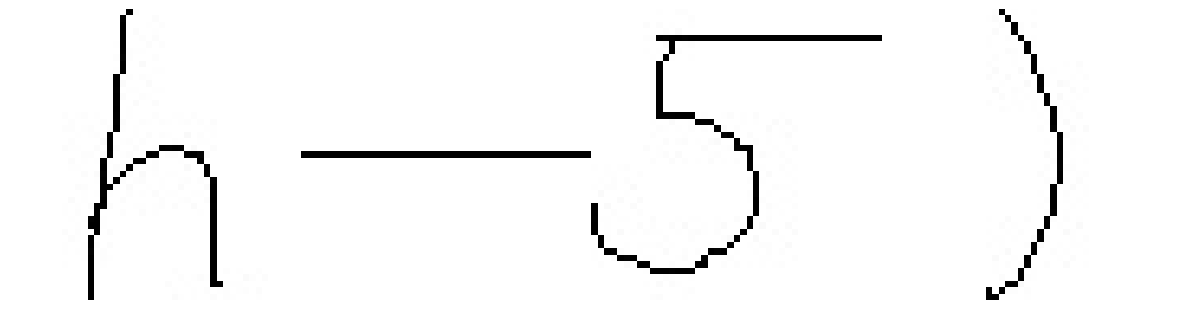

Изображение сохранено в saved_pic.png


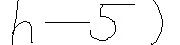

In [9]:
# Генерируем случайное выражение
expr = generate_expression()
expr_str = ''.join(expr)
print(f"Сгенерированное выражение: {expr_str}")

# Генерируем изображение выражения и сохраняем его
image_path = 'saved_pic.png'
generate_expression_with_images(expr, save_path=image_path)

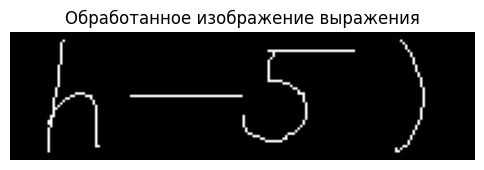

In [10]:
# Загружаем изображение
img = cv2.imread('saved_pic.png')

# Преобразуем в градации серого
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Применяем эрозию для уменьшения мелких шумов
kernel = np.ones((1, 1), np.uint8)
img_gray = cv2.erode(img_gray, kernel, iterations=1)

# Инвертируем изображение (чтобы символы были белыми на черном фоне)
img_gray = cv2.bitwise_not(img_gray)

# Добавляем небольшое обрамление вокруг изображения
padding = 3
base_size = (img_gray.shape[0] + 2 * padding, img_gray.shape[1] + 2 * padding)
base = np.zeros(base_size, dtype=np.uint8)

# Вставляем исходное изображение по центру с отступами
base[padding:padding + img_gray.shape[0], padding:padding + img_gray.shape[1]] = img_gray

# Преобразуем в RGB для отображения через matplotlib
img_rgb = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)

# Отображаем результат
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.title("Обработанное изображение выражения")
plt.axis('off')
plt.show()

Размеры бинаризованного изображения: (51, 186, 3)


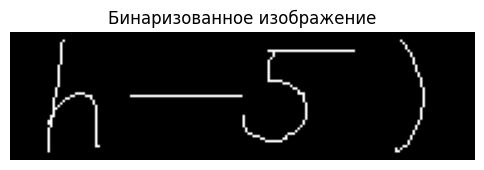

In [11]:
# Применяем пороговую бинаризацию к изображению
ret_value, thresh_image = cv2.threshold(img_rgb, thresh=127, maxval=255, type=cv2.THRESH_BINARY)

# Для совместимости: гарантируем тип uint8
thresh_image = np.uint8(thresh_image)

# Выводим размерность для дебага
print(f"Размеры бинаризованного изображения: {thresh_image.shape}")

# Отображаем результат
plt.figure(figsize=(6, 6))
plt.imshow(thresh_image)
plt.title("Бинаризованное изображение")
plt.axis('off')
plt.show()

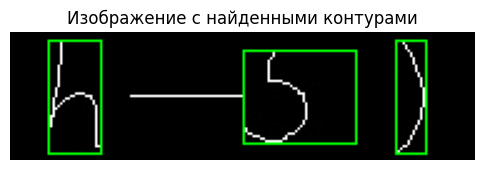

Координаты найденных областей: [(93, 7, 45, 37), (154, 3, 12, 45), (15, 3, 21, 45)]


In [12]:
# Найдём внешние контуры на первом канале бинаризованного изображения
contours, _ = cv2.findContours(
    thresh_image[:, :, 0], 
    mode=cv2.RETR_EXTERNAL, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

crops = []
for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(cnt)

    # Фильтруем слишком маленькие области
    if w * h > 50:
        # Рисуем прямоугольник на изображении
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), color=(0, 255, 0), thickness=1)  # зелёный цвет

        # Бинаризуем обрезанный участок (можно использовать как признаки для классификации)
        _, cropped_thresh = cv2.threshold(
            img_gray[y:y+h, x:x+w],
            thresh=127,
            maxval=255,
            type=cv2.THRESH_BINARY
        )

        crops.append((x, y, w, h))  # Сохраняем координаты обрезанной области

# Конвертируем обратно в RGB для корректного отображения через matplotlib
img_bgr_to_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)

# Отображаем результат
plt.figure(figsize=(6, 6))
plt.imshow(img_bgr_to_rgb)
plt.title("Изображение с найденными контурами")
plt.axis('off')
plt.show()

print("Координаты найденных областей:", crops)

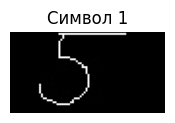

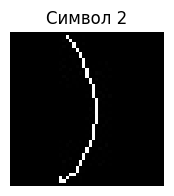

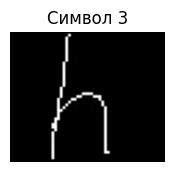

In [13]:
data_img = []

for i, (x, y, w, h) in enumerate(crops):
    # Расширяем границы области для лучшего контекста
    x -= 3
    y -= 3
    w += 5
    h += 3

    # Обрезаем участок изображения с учетом новых границ
    cropped_img = img_gray[y:y+h, x:x+w]

    # Создаём новый холст с дополнительными отступами по краям
    base_height = cropped_img.shape[0] + 2
    base_width = cropped_img.shape[1] + 30
    base = np.zeros((base_height, base_width), dtype=np.uint8)

    # Вставляем изображение по центру с горизонтальным смещением
    padding_left_right = 15
    base[1:cropped_img.shape[0]+1, padding_left_right:padding_left_right+cropped_img.shape[1]] = cropped_img

    # Добавляем результат в список данных
    data_img.append((x, base))

    # Отображаем изображение для проверки
    plt.figure(figsize=(2, 2))
    plt.imshow(base, cmap="gray")
    plt.title(f"Символ {i+1}")
    plt.axis("off")
    plt.show()

# Бинарная строка

Сгенерированное выражение: (7-4)


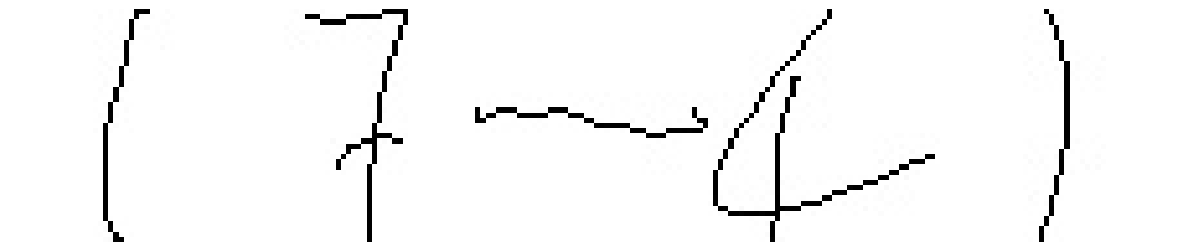

Изображение сохранено в saved_pic1.png

Бинарная строка (первые 500 символов):
11111111111111111111111100011111111111111111111111111111111111111111111100000111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111011111111111111111111111111111111111111111111111101111111111111111111111111111111100011111000000011110111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111101111111111111111111111111111111111111111111111011111111111111111111111111...


In [14]:
def image_to_binary_string(image: Image.Image | np.ndarray) -> str:
    """
    Преобразует изображение (PIL.Image или NumPy array) в бинарную строку.

    Изображение сначала конвертируется в градации серого, затем применяется 
    пороговое преобразование (128), после чего пиксели выстраиваются в строку '0' и '1'.

    Args:
        image (Image.Image or np.ndarray): Входное изображение (RGB, BGR или grayscale).

    Returns:
        str: Бинарная строка, представляющая изображение.
    """
    # Конвертация PIL Image в numpy array
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image

    # Если изображение цветное — переводим в оттенки серого
    if len(image_np.shape) == 3:
        gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image_np

    # Применяем пороговое преобразование
    _, binary_image = cv2.threshold(gray_image, thresh=128, maxval=1, type=cv2.THRESH_BINARY)

    # Преобразуем массив в одномерный и создаём строку из 0 и 1
    binary_string = ''.join(str(bit) for bit in binary_image.flatten())

    return binary_string


# --- Пример использования ---
if __name__ == "__main__":
    # Генерируем выражение и сохраняем как изображение
    expr = generate_expression()
    print(f"Сгенерированное выражение: {''.join(expr)}")
    
    pic = generate_expression_with_images(expr, save_path='saved_pic1.png')

    # Преобразуем изображение в бинарную строку
    binary_str = image_to_binary_string(pic)

    # Выводим результат
    print(f"\nБинарная строка (первые 500 символов):\n{binary_str[:500]}...")